# TP1 : Algorithme EM et modèle de mélange gaussien

## Introduction à l'estimation statistique - G3 SDIA

L'objectif de ce TP est d'implémenter l'algorithme EM pour estimer par maximum de vraisemblance les paramètres d'un modèle de mélange gaussien.

On utilisera le dataset *Old Faithful*, qui décrit 272 éruptions du geyser appelé Old Faithful du parc national de Yellowstone aux États-Unis. Chaque observation est constituée de 2 variables : le temps d'attente avant l'éruption (en minutes) et la durée de l'éruption (en minutes).

### Instructions

1. Renommer votre notebook sous la forme `tp1_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 15 Octobre 2023, 23h59.

In [1]:
# Import necessary libraries
import numpy as np
import scipy.stats as ss
import seaborn
from matplotlib import pyplot as plt
import pandas as pd
import io
import requests
from sklearn.preprocessing import StandardScaler

**Q1**. Charger le dataset, normaliser puis visualiser les données. Commenter.

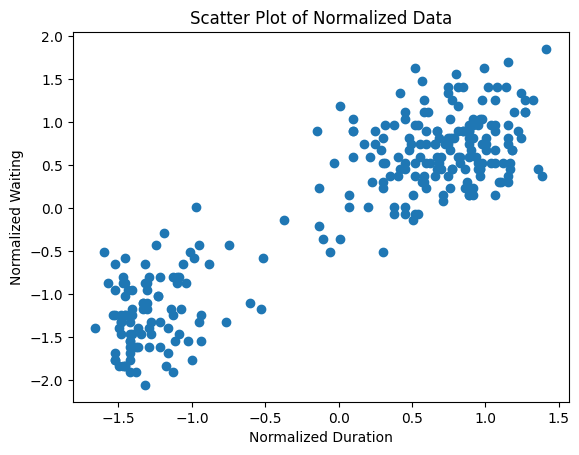

In [2]:
# Loading of data
url = "https://github.com/mwaskom/seaborn-data/raw/master/geyser.csv"
response = requests.get(url)
data = io.StringIO(response.text)
df = pd.read_csv(data)
X = df[['duration', 'waiting']].values
N, D = X. shape

# Standardize data to avoid numerical instabilities
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Show data
plt.scatter(X_normalized[:, 0], X_normalized[:, 1])
plt.title('Scatter Plot of Normalized Data')
plt.xlabel('Normalized Duration')
plt.ylabel('Normalized Waiting')
plt.show()

**Réponse:** On observe que les données sont plutôt réparties en deux clusters.

**Q2**. On note $\mathbf{x}_1,...,\mathbf{x}_n$ les données. On souhaite les modéliser par un modèle de mélange gaussien à $K$ composantes.

Écrire une fonction permettant de calculer la log-vraisemblance :
$$ \log \mathcal{L}(\theta;\mathbf{x}_1,...,\mathbf{x}_n) = \sum_{i=1}^n \log \left( \sum_{k=1}^K \pi_k \frac{1}{2 \pi \text{det}(\boldsymbol{\Sigma}_k)^{1/2}} \exp \left( \frac{1}{2} (\mathbf{x}_i - \boldsymbol{\mu}_k)^{\top} \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_k) \right) \right), $$
avec $\theta = \{ \boldsymbol{\mu_1}, ..., \boldsymbol{\mu_K}, \boldsymbol{\Sigma}_1, ..., \boldsymbol{\Sigma}_K, \pi_1, ..., \pi_K \}$.

On pourra utiliser la fonction $\texttt{multivariate} \_ \texttt{normal.pdf}$ de la librairie scipy.stats.

In [3]:
def log_likelihood(theta, X):
    """theta = (mu, Sigma, pi) = ([mu_1, ..., mu_K], [Sigma_1, ..., Sigma_K], [pi_1, ..., pi_K])
    K est le nombre de paramètres
    mu est la liste des moyennes (K*1)
    Sigma est la liste des matrices de covariances (K*K)
    pi est la liste des poids don la somme est égale à 1 (scalaires)
    
    Exemple: log_likelihood(([[0, 0], [0, 0]], [[[1, 0], [0, 1]], [[1, 0], [0, 1]]], [0.5, 0.5]), X_normalized)
    """
    N, D = X. shape
    K = len(theta[0])
    mu, Sigma, pi = theta
    likelihood = 0
    for i in range(N):
        likelihood_i = 0
        for k in range(K):
            likelihood_i += pi[k] * ss.multivariate_normal.pdf(X[i], mean=mu[k], cov=Sigma[k])
        likelihood += np.log(likelihood_i)
    return likelihood

**Q3**. Écrire une fonction qui implémente l'algorithme EM dans ce modèle, prenant pour arguments les données, le nombre de composantes $K$, et le nombre d'itérations de l'algorithme $N_{\text{iter}}$. Cette fonction retournera un tableau de taille $N_{\text{iter}} + 1$ contenant l'évolution des valeurs de la log-vraisemblance, ainsi que les valeurs finales des paramètres.

Initialisation des paramètres :
- Pour les moyennes, les $K$ premières observations du dataset ;
- Pour les matrices de covariances, la matrice identité ;
- $\pi_k = 1/K$.

In [4]:
def EM_algorithm_v1(X, K, Niter):
    N, D = X.shape
    
    # Initialize parameters
    mu = X[:K]
    Sigma = [np.eye(D) for _ in range(K)]
    pi = np.ones(K) / K
    like = []

    for iteration in range(Niter):
        # E-STEP
        R = np.zeros((N, K))
        for k in range(K):
            R[:, k] = pi[k] * ss.multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k])
        R /= np.sum(R, axis=1, keepdims=True)
        
        # M-STEP
        Nk = np.sum(R, axis=0)
        pi = Nk / N

        mu = np.dot(R.T, X) / Nk[:, np.newaxis]

        for k in range(K):
            diff = X - mu[k]
            Sigma[k] = np.dot(R[:, k] * diff.T, diff) / Nk[k]
        like.append(log_likelihood((mu, Sigma, pi), X))

    return mu, Sigma, pi, like

**Q4**. Faire tourner l'algorithme avec $K = 2$ et $N_{\text{iter}} = 50$.

Afficher l'évolution de la log-vraisemblance en fonction des itérations. Commenter.

Sur une même figure, afficher le dataset et représenter les estimations des deux lois normales du mélange à l'aide d'un *contour plot*. On pourra utiliser la fonction $\texttt{plt.contour}$.

In [5]:
def plot_gaussian_mixture(X, means, covariances):
    plt.figure(figsize=(8, 6))
    
    # Plot the dataset
    plt.scatter(X[:, 0], X[:, 1], label='Data')
    plt.scatter(means[:, 0], means[:, 1])
    
    # Create a grid of values for the contour plot
    x, y = np.meshgrid(np.linspace(X[:, 0].min()-0.25, X[:, 0].max()+0.25, 100),
                       np.linspace(X[:, 1].min()-0.25, X[:, 1].max()+0.25, 100))
    
    # Evaluate the Gaussian mixture model on the grid
    z = np.zeros_like(x)
    for mean, cov in zip(means, covariances):
        mvn = ss.multivariate_normal(mean=mean, cov=cov)
        z += mvn.pdf(np.dstack((x, y)))

    # Plot the contour lines for the Gaussian mixture
    plt.contour(x, y, z, colors='g', linestyles='dashed', linewidths=0.7, levels=5)
    plt.title('Scatter Plot of Normalized Data')
    plt.xlabel('Normalized Duration')
    plt.ylabel('Normalized Waiting')
    plt.legend()
    plt.grid(True)
    plt.show()


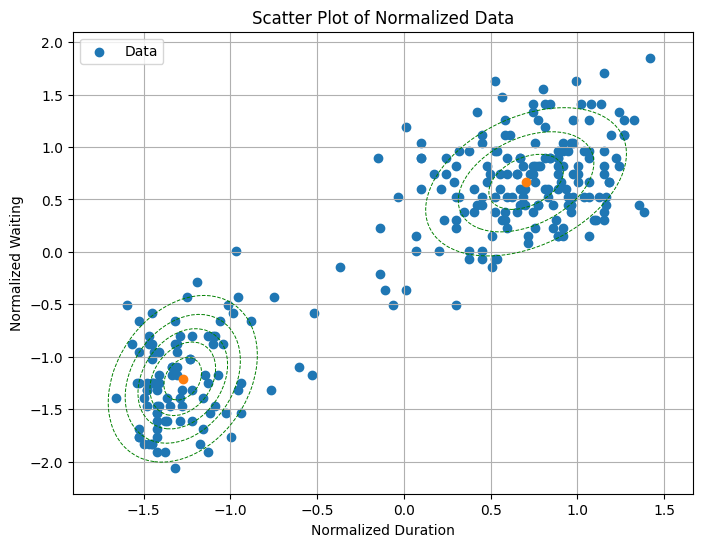

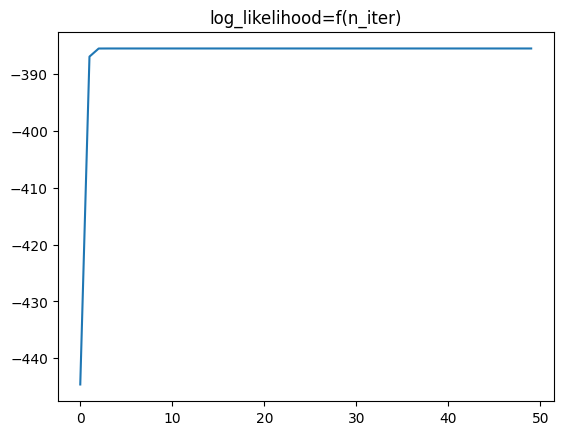

In [6]:
K = 2
Niter = 50

mu, Sigma, pi, like = EM_algorithm_v1(X_normalized, K, Niter)

plot_gaussian_mixture(X_normalized, mu, Sigma)

plt.plot(like)
plt.title('log_likelihood=f(n_iter)')
plt.show()

**Commentaire** :On remarque que la log-vraissemblance converge très rapidement avec cette initialisation. Moins de 5 itération suffisent à arriver à la valeur de convergence.

**Q5**. On souhaite maintenant étudier l'influence de l'initialisation sur les résultats. Modifier la fonction implémentant l'algorithme EM en y rajoutant un argument pour la graine aléatoire. Les paramètres seront maintenant initialisés de la manière suivante :
- $\boldsymbol{\mu}_k \sim \mathcal{N}(\mathbf{0},\mathbf{I}_2)$ ;
- $[\pi_1, ..., \pi_K]^{\top} \sim \text{Dirichlet}([1, ..., 1]^{\top})$ ;
- On gardera l'initialisation des matrices de covariance à la matrice identité.

In [7]:
def EM_algorithm_v2(X, K, Niter, seed):
    N, D = X. shape
    
    # Initialize parameters
    np.random.seed(seed)

    # Initialize parameters
    mu = np.random.normal(0, 1, size=(K, 2))
    pi = np.random.dirichlet(np.ones(K))
    Sigma = np.array([np.eye(2) for _ in range(K)])
    like = []

    for iteration in range(Niter):
        # E-STEP
        R = np.zeros((N, K))
        for k in range(K):
            R[:, k] = pi[k] * ss.multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k])
        R /= np.sum(R, axis=1, keepdims=True)
        
        # M-STEP
        Nk = np.sum(R, axis=0)
        pi = Nk / N

        mu = np.dot(R.T, X) / Nk[:, np.newaxis]

        for k in range(K):
            diff = X - mu[k]
            Sigma[k] = np.dot(R[:, k] * diff.T, diff) / Nk[k]
        like.append(log_likelihood((mu, Sigma, pi), X))

    return mu, Sigma, pi, like

**Q6**. On choisit maintenant $K=3$. Représenter l'évolution de la log-vraisemblance pour 10 graines aléatoires différentes. Commenter.

Afficher deux cas où la solution retournée par l'algorithme EM est visuellement différente. Commenter.

Quelle estimation de paramètres doit-on choisir ?

In [8]:
K = 3
Seed=[i for i in range(5,16)]
seed_10_run=[EM_algorithm_v2(X_normalized,3,50,seed) for seed in Seed]

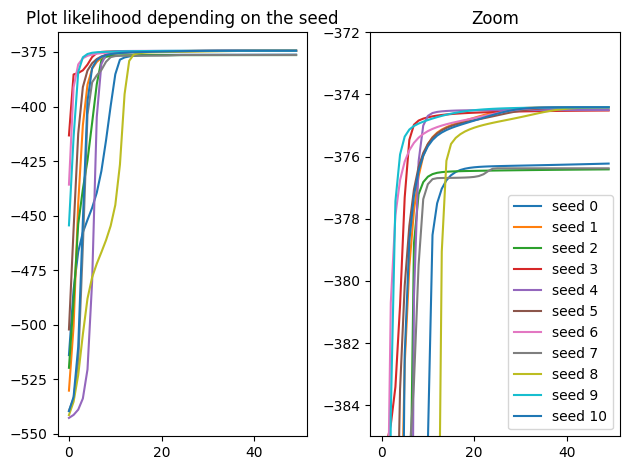

In [9]:
plt.subplot(1, 2, 1)  # Le premier graphe
for i in range (len(seed_10_run)):
    plt.plot(seed_10_run[i][3], label=f'seed {i}')
    plt.title('Plot likelihood depending on the seed')
    
plt.subplot(1, 2, 2)  # Le deuxième graphe
for i in range (len(seed_10_run)):
    plt.plot(seed_10_run[i][3], label=f'seed {i}')
    plt.title('Zoom')
    plt.ylim(-385, -372)  # Limites pour l'axe y

plt.tight_layout()
plt.legend()
plt.show()

**Commentaire :** On remarque que en zommant sur les différentes courbes, les valeurs de convergence de la Log-likelhood diffèrent ce qui suggère des valuers différentes pour nos paramètres de clusters.Comme le montre les plots ci-dessous, les centres et orientations des différentes distributions changent (maxima locaux)

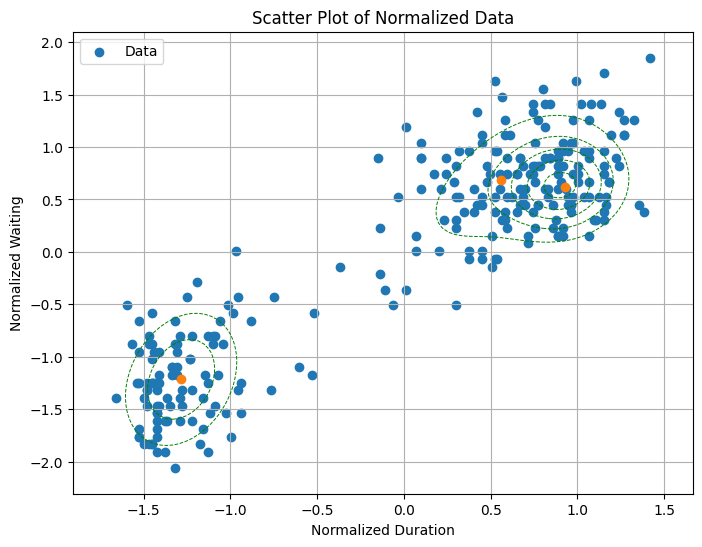

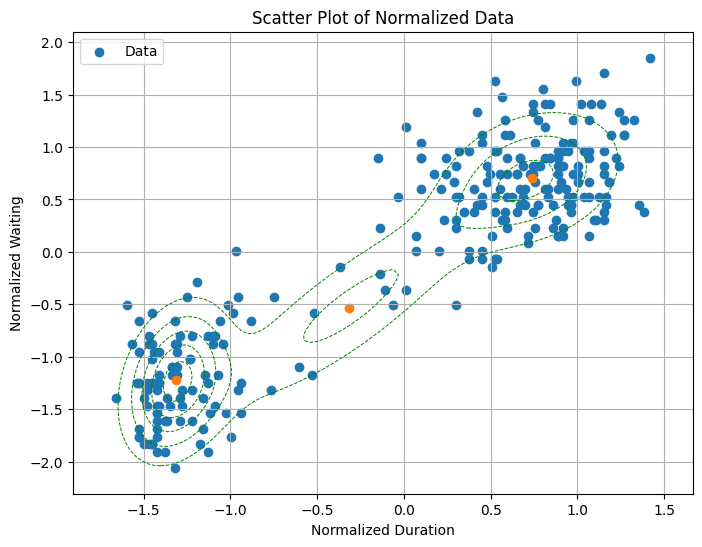

In [10]:
index_seed=[2,3]
for i in index_seed:
    plot_gaussian_mixture(X_normalized,seed_10_run[i][0],seed_10_run[i][1])

**Q7**. On cherche maintenant à choisir la valeur optimale de $K$. Pour cela, on aimerait pouvoir comparer la vraisemblance des modèles obtenus avec différentes valeurs de $K$.

Cela peut se faire au travers d'un critère de sélection de modèle. Dans ce TP, nous étudierons le critère dit BIC :
$$ \text{BIC}(m) = k(m) \log(n) - 2 \log \mathcal{L}(m),$$
où $m$ est un modèle (ici donné par une valeur de $K$), $k_m$ est le nombre de paramètres libres dans le modèle, $n$ le nombre d'échantillons, et $\mathcal{L}_m$ le maximum de la fonction de vraisemblance de le modèle $m$. On sélectionne le modèle avec le plus faible BIC.

Montrer que $$k(m) = \frac{K}{2} (D+1)(D+2) - 1.$$

Comparer les valeurs de $K$ allant de 1 à 6. Quel est le modèle optimal d'après le critère BIC ?

In [11]:
def BIC(K,N_iter):
    N,D = X_normalized.shape 
    mod=EM_algorithm_v2(X_normalized,K,N_iter,10)
    k_m=(K*(D+1)*(D+2)/2)-1
    bic=k_m*np.log(N)-2*(max(mod[3]))
    return(bic)

In [12]:
K=[i for i in range(1,7)]
bic=[BIC(k,20) for k in K ]


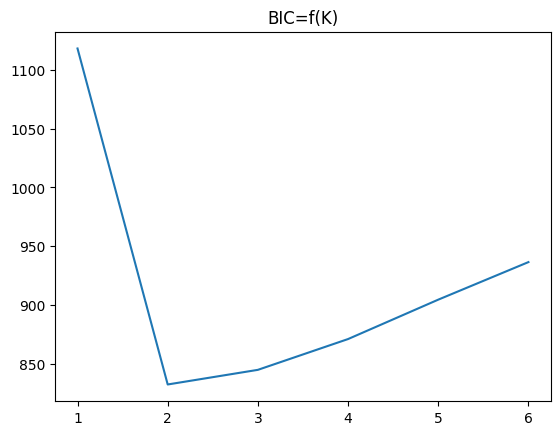

In [13]:
plt.plot(K,bic)
plt.title('BIC=f(K)')
plt.show()

**Réponse:** Au regard du critère BIC, le modèle optimal est un modèle à 2 clusters. Ce modèle corrobore ce que l'intuition suggère: on a en effet envie de regrouper les points en 2 groupes (visuellement).

**Question bonus**. Expliquer comment l'algorithme EM peut-être utilisé pour du clustering.

L'algorithme Expectation-Maximization (EM) est utilisé pour le clustering en estimant les paramètres d'un modèle de mélange de gaussiennes. Initialement, les paramètres sont initialisés, comprenant les moyennes, les covariances et les poids des composantes. Ensuite, dans l'Étape d'Expectation (E-step), les probabilités d'appartenance à chaque composante sont calculées pour chaque point. L'Étape de Maximisation (M-step) met à jour les paramètres pour maximiser la vraisemblance conditionnelle. Ces deux étapes sont répétées jusqu'à la convergence. Une fois les paramètres stabilisés, les points sont affectés au cluster avec la plus haute probabilité. L'EM pour le clustering est utile car il n'exige pas de définir a priori le nombre de clusters et peut modéliser des clusters complexes. Cependant, il peut converger vers des optima locaux, nécessitant des initialisations multiples pour obtenir le meilleur regroupement.